In [1]:
import pyarrow.parquet as pq
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2021-12-02 17:37:34.343970: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-02 17:37:34.343991: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0,
                               patience = 30,
                               verbose=2,
                               mode='min')
# Stop the learning when val_loss stops increasing 
# https://keras.io/api/callbacks/early_stopping/

reduce_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                                   factor = 0.1,
                                   min_delta = 0,
                                   patience = 10,
                                   verbose=2,
                                   mode='min')
# reduce LR if not improvement for some time 
# https://keras.io/api/callbacks/reduce_lr_on_plateau/ 

In [3]:
df = pd.read_parquet("Skim_neweta.parquet")

In [4]:
df["label"] = 0
df = df[df['weight']>0]

In [5]:
print(df)

        weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0     0.000025 -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   
1     0.000025  1.871283  1.047394   2.573060    0.773788  0.890115 -2.034852   
2     0.000025  2.091786 -1.589172   3.478898    0.846155  1.033298  2.798018   
3     0.000025  0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
4     0.000025 -0.222354  0.316651   2.682673    2.617695  0.326127  0.229977   
...        ...       ...       ...        ...         ...       ...       ...   
3691  0.784736  1.767487 -2.685603   2.533158    0.840620  2.022784  1.191282   
3692  0.784736 -0.761641 -1.350025   1.366371    1.047554 -2.588544 -0.412600   
3693  0.784736  0.137637  2.189009   0.688119    0.681652  1.682014  0.102387   
3694  0.784736  0.118838 -2.689873   0.456992    0.453784 -2.057512  0.021551   
3695  0.784736  1.119464  2.110899   1.128419    0.665800  1.023254 -1.432882   

      E_mGG_ph2  pT_mGG_ph2

In [6]:
df.loc[df.process.str.contains("HHH"), ['label']] = 1

In [7]:
batch_size = 128


def checkBatches(df):
    N_checks = 1000
    sum_sig = 0.
    N_sig = 0
    sum_back = 0.
    N_back = 0
    for i in range(N_checks):
        rnd_df = df.sample(batch_size)
        sum_sig  += rnd_df[rnd_df['label']==1]['weight'].sum()
        sum_back += rnd_df[rnd_df['label']==0]['weight'].sum()
        N_sig    += rnd_df[rnd_df['label']==1].shape[0]
        N_back   += rnd_df[rnd_df['label']==0].shape[0]
    sum_sig  /= N_checks
    sum_back /= N_checks
    N_sig    /= N_checks
    N_back   /= N_checks

    print (f'On average, per batch the total learning weight is\n\t... signal     : {sum_sig:12.6f} [{N_sig} events] \n\t... background : {sum_back:12.6f} [{N_back} events]')



In [8]:
checkBatches(df)

On average, per batch the total learning weight is
	... signal     :     0.000776 [30.416 events] 
	... background :  5554.040672 [97.584 events]


In [9]:
print(df)

        weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0     0.000025 -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   
1     0.000025  1.871283  1.047394   2.573060    0.773788  0.890115 -2.034852   
2     0.000025  2.091786 -1.589172   3.478898    0.846155  1.033298  2.798018   
3     0.000025  0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
4     0.000025 -0.222354  0.316651   2.682673    2.617695  0.326127  0.229977   
...        ...       ...       ...        ...         ...       ...       ...   
3691  0.784736  1.767487 -2.685603   2.533158    0.840620  2.022784  1.191282   
3692  0.784736 -0.761641 -1.350025   1.366371    1.047554 -2.588544 -0.412600   
3693  0.784736  0.137637  2.189009   0.688119    0.681652  1.682014  0.102387   
3694  0.784736  0.118838 -2.689873   0.456992    0.453784 -2.057512  0.021551   
3695  0.784736  1.119464  2.110899   1.128419    0.665800  1.023254 -1.432882   

      E_mGG_ph2  pT_mGG_ph2

In [10]:
print (f"Sum of learning weight for signal     = {df[df['label']==1]['weight'].sum():15.5f}")
print (f"Sum of learning weight for background = {df[df['label']==0]['weight'].sum():15.5f}")
df.loc[df['label']==1,'weight'] *= df.shape[0]/2 / df[df['label']==1]['weight'].sum() 
df.loc[df['label']==0,'weight'] *= df.shape[0]/2 / df[df['label']==0]['weight'].sum()
# We divide by their sum, and multiply by the number of events
#   First part is so that the sum of weights of the signal is now == to the background ones
#   The second part is because if the weights are super small, the loss will be small
#       In practice the magnitude does not matter, only relative difference, but it is easier
#       to check the learning when the loss variations are not far in the decimals
#       -> like that the average unit weight is 1
print ("After equalization")
print (f"Sum of learning weight for signal     = {df[df['label']==1]['weight'].sum():15.5f}")
print (f"Sum of learning weight for background = {df[df['label']==0]['weight'].sum():15.5f}")

print (f'Average learning weight = {df["weight"].mean()}')

print ('\nNow let us try again with batches')

Sum of learning weight for signal     =         1.62564
Sum of learning weight for background =  11460936.00000
After equalization
Sum of learning weight for signal     =    133674.53125
Sum of learning weight for background =    133674.51562
Average learning weight = 1.0

Now let us try again with batches


In [11]:
checkBatches(df)

On average, per batch the total learning weight is
	... signal     :    64.027371 [30.536 events] 
	... background :    71.817092 [97.464 events]


In [12]:
input_vars=["Eta_ph1","Phi_ph1","E_mGG_ph1","pT_mGG_ph1","Eta_ph2","Phi_ph2","E_mGG_ph2","pT_mGG_ph2","Electron_E","Electron_pT","Electron_Eta","Electron_Phi","Muon_E","Muon_pT","Muon_Eta","Muon_Phi","nJets","E_jet1","pT_jet1","Eta_jet1","Phi_jet1","E_jet2","pT_jet2","Eta_jet2","Phi_jet2","InvM_jet","InvM_jet2", "met"]

In [13]:
print(df[input_vars])

       Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0    -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   
1     1.871283  1.047394   2.573060    0.773788  0.890115 -2.034852   
2     2.091786 -1.589172   3.478898    0.846155  1.033298  2.798018   
3     0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
4    -0.222354  0.316651   2.682673    2.617695  0.326127  0.229977   
...        ...       ...        ...         ...       ...       ...   
3691  1.767487 -2.685603   2.533158    0.840620  2.022784  1.191282   
3692 -0.761641 -1.350025   1.366371    1.047554 -2.588544 -0.412600   
3693  0.137637  2.189009   0.688119    0.681652  1.682014  0.102387   
3694  0.118838 -2.689873   0.456992    0.453784 -2.057512  0.021551   
3695  1.119464  2.110899   1.128419    0.665800  1.023254 -1.432882   

      E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
0      2.815203    0.482479   32.269810    30.670956  ...   75.722549   
1

In [14]:
df_clean = df[input_vars].copy()
df_clean["label"] = df.loc[:,"label"]
df_clean.to_csv("dataframe_HHWWgg.csv")


In [15]:
X_train, X_test, y_train, y_test,w_train, w_test = train_test_split(df[input_vars], df.label, df.weight, 
                                                    test_size=0.33, random_state=42)

In [16]:
print(X_train)

         Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
35231  -1.945764 -3.062029   2.268816    0.635358 -0.550223 -2.298545   
8868   -1.820626 -0.043045   2.502725    0.789796 -2.617009 -2.681274   
71095   0.099085 -0.838356   0.544916    0.542252  0.862605  2.181485   
114269  1.282274 -2.663917   3.101353    1.597716  0.192350 -2.408060   
36454   1.539533 -1.002441   1.515589    0.621539  1.482318  1.691988   
...          ...       ...        ...         ...       ...       ...   
81876   0.373729 -2.581681   0.944210    0.881901  0.192384 -0.985424   
46     -2.201052 -2.005043   2.970534    0.649638 -1.052876  1.749613   
99997  -1.264996 -1.493569   0.969339    0.506802  0.020675  2.340647   
122596  0.644087 -2.541043   1.332074    1.096632 -0.388746  2.307051   
85023   1.311740  2.135893   2.354585    1.182620  0.749861 -0.459073   

        E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
35231    0.640226    0.554198    0.000000     0.

In [17]:
print(X_test)

         Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
3329    1.087376  0.904130   0.406792    0.246274 -1.648648 -3.020724   
2789    0.358049 -0.526940   0.437181    0.410581 -1.190133  2.006132   
15599  -1.195990 -2.027550   1.659136    0.919384 -1.642366  2.936179   
64363   1.061911 -2.731441   1.322440    0.816904  0.518941 -1.094325   
4149    1.903018 -1.843503   7.791508    2.273160  2.293625 -0.882963   
...          ...       ...        ...         ...       ...       ...   
2479   -0.581940  2.039370   0.636352    0.541964  0.964338 -2.795501   
126114 -1.491346  0.421756   3.139447    1.345052 -0.678817 -1.530567   
21718   1.412178  2.301200   1.858807    0.854919  0.758501  0.108824   
102035  0.152458 -2.928749   1.387487    1.371517 -0.176697  1.881357   
139654  0.053975  1.505935   0.673873    0.672893  0.499380 -1.281240   

        E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
3329     0.647501    0.240160    0.000000     0.

In [18]:
inputs = keras.Input(shape=(len(input_vars),), name="particles")
x = layers.Dense(128, activation="relu", name="dense_1")(inputs)
x = layers.Dense(128, activation="relu", name="dense_2")(x)
x = layers.Dense(128, activation="relu", name="dense_3")(x)
x = layers.Dense(128, activation="relu", name="dense_4")(x)
outputs = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

2021-12-02 17:38:17.192321: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-02 17:38:17.192356: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-02 17:38:17.192381: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (1S0): /proc/driver/nvidia/version does not exist
2021-12-02 17:38:17.192607: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
model.compile(
    #optimizer=keras.optimizers.Adam(learning_rate=0.01),  # Optimizer
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [25]:
X_val = X_train[-3000:]
y_val = y_train[-3000:]
w_val = w_train[-3000:]
X_train = X_train[:-3000]
y_train = y_train[:-3000]
w_train = w_train[:-3000]

In [26]:
print(X_train)

         Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
35231  -1.945764 -3.062029   2.268816    0.635358 -0.550223 -2.298545   
8868   -1.820626 -0.043045   2.502725    0.789796 -2.617009 -2.681274   
71095   0.099085 -0.838356   0.544916    0.542252  0.862605  2.181485   
114269  1.282274 -2.663917   3.101353    1.597716  0.192350 -2.408060   
36454   1.539533 -1.002441   1.515589    0.621539  1.482318  1.691988   
...          ...       ...        ...         ...       ...       ...   
10862   0.030158 -1.892077   0.667419    0.667116  1.283620  1.808410   
80501   0.353667  1.010400   0.576383    0.542124  1.900531 -2.744256   
99048  -1.091082 -1.429448   1.080760    0.652367 -1.070899  2.733089   
100508  1.397039  1.498880   1.691922    0.788676  0.986889 -1.721251   
3690    0.391979  1.737296   0.719422    0.667484 -0.224936 -1.742447   

        E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
35231    0.640226    0.554198    0.000000     0.

In [27]:
history = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=1000,
    sample_weight=w_train,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, y_val,w_val),
    callbacks = [early_stopping,reduce_plateau],
)

Epoch 1/1000
1353/1353 [==============================] - 3s 2ms/step - loss: 0.6713 - binary_accuracy: 0.2394 - val_loss: 0.7271 - val_binary_accuracy: 0.2300 - lr: 0.0010
Epoch 2/1000
1353/1353 [==============================] - 3s 2ms/step - loss: 0.6790 - binary_accuracy: 0.2394 - val_loss: 0.7422 - val_binary_accuracy: 0.2300 - lr: 0.0010
Epoch 3/1000
1353/1353 [==============================] - 2s 2ms/step - loss: 0.6872 - binary_accuracy: 0.2394 - val_loss: 0.7544 - val_binary_accuracy: 0.2300 - lr: 0.0010
Epoch 4/1000
1353/1353 [==============================] - 2s 2ms/step - loss: 0.6910 - binary_accuracy: 0.2394 - val_loss: 0.7649 - val_binary_accuracy: 0.2300 - lr: 0.0010
Epoch 5/1000
1353/1353 [==============================] - 2s 2ms/step - loss: 0.7019 - binary_accuracy: 0.2394 - val_loss: 0.7706 - val_binary_accuracy: 0.2300 - lr: 0.0010
Epoch 6/1000
1353/1353 [==============================] - 3s 2ms/step - loss: 0.7026 - binary_accuracy: 0.2394 - val_loss: 0.7700 - val

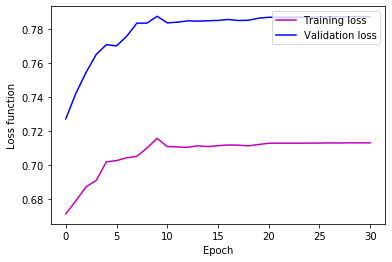

In [28]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],color='m',label='Training loss')
plt.plot(history.history['val_loss'],color='b',label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='upper right')
plt.savefig('training_validation.pdf')
plt.show()

[[0.664275]
 [0.664275]
 [0.664275]
 ...
 [0.664275]
 [0.664275]
 [0.664275]]
[0. 1.]
[0. 1.]
[1.6642749 0.664275 ]


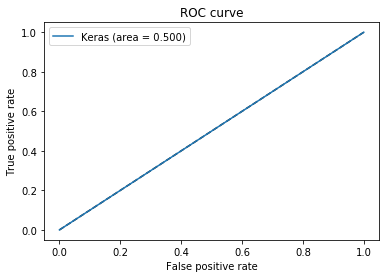

In [29]:
prediction = model.predict(X_test)
from sklearn.metrics import roc_curve
#y_pred_keras = keras_model.predict(X_test).ravel()
#idx = y_test > 0
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, prediction,sample_weight=w_test)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

print(prediction)
print(fpr_keras)
print(tpr_keras)
print(thresholds_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='XGBoost (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("ROC_curve.pdf")
plt.show()

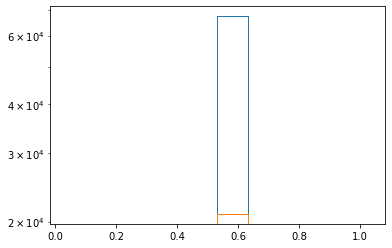

In [25]:
plt.hist(prediction[y_test==0],histtype=("step"));
plt.hist(prediction[y_test==1],histtype=("step"));
plt.yscale('log') 
plt.savefig("prediction.pdf", dpi = 300)

In [47]:
# evaluate the model
scores = model.evaluate(X_test, y_test, w_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

3460/3460 - 2s - loss: 0.3782 - binary_accuracy: 0.8355 - 2s/epoch - 459us/step
binary_accuracy: 83.55%


In [48]:
# save model and architecture to single file
model.save("model_dnn_neweta")
print("Saved model to disk")

INFO:tensorflow:Assets written to: model_dnn_neweta/assets
Saved model to disk
